# Tokopedia Product Sentiment

In [1]:
from tqdm.notebook import tqdm

tqdm.pandas()

## Data Loading

In [2]:
import pandas as pd

df = pd.read_json(path_or_buf='data/reviews.jsonl', lines=True)
df.head()

,product_id,product_url,shop_id,shop_name,shop_url,review_id,star,review,source,variant_name,is_anonymous
0,,https://www.tokopedia.com/merriesofficial/flas...,,None,https://www.tokopedia.com/merriesofficial,,5,"Barang yg dibeli sesuai , pengiriman cepat dan...",html,,
1,,https://www.tokopedia.com/merriesofficial/flas...,,None,https://www.tokopedia.com/merriesofficial,,5,Barang Original!!! Packing sangat aman... Grea...,html,,
2,,https://www.tokopedia.com/merriesofficial/flas...,,None,https://www.tokopedia.com/merriesofficial,,5,Pengiriman sangat cepat!!! pesan hari ini bes...,html,,
3,8536883143,https://www.tokopedia.com/winodofficialshop/wi...,11061624,winod,https://www.tokopedia.com/winodofficialshop,914575864,5,ini rekomen banget.. yg beli ga bakal nyesel.....,api,Black - 37,False
4,8536883143,https://www.tokopedia.com/winodofficialshop/wi...,11061624,winod,https://www.tokopedia.com/winodofficialshop,1243605012,5,"so cute, ukurannya pas, sendalnya ringan dan n...",api,Ivory - 38,True


In [3]:
df.star.value_counts()

star
5    3626
4     215
3      88
1      71
2      34
Name: count, dtype: int64

## Assessing Data

In [4]:
df[['review', 'star']].isna().sum()

review    123
star        0
dtype: int64

In [5]:
df.dropna(subset='review', inplace=True)
df[['review', 'star']].head()

,review,star
0,"Barang yg dibeli sesuai , pengiriman cepat dan...",5
1,Barang Original!!! Packing sangat aman... Grea...,5
2,Pengiriman sangat cepat!!! pesan hari ini bes...,5
3,ini rekomen banget.. yg beli ga bakal nyesel.....,5
4,"so cute, ukurannya pas, sendalnya ringan dan n...",5


In [6]:
df[df.duplicated(subset='review', keep=False)]['review']

37                                           Good quality
38                                Bagus sesuai ekspektasi
40                                                   good
49                                                 mantap
50                                                 mantap
                              ...                        
4016    Mantap gan barangnya 👍🏻💯\nSukses terus buatlap...
4017    Mantap gan barangnya 👍🏻💯\nSukses terus buatlap...
4023               Kualitasnya bagus dan sesuai deskripsi
4024               Kualitasnya bagus dan sesuai deskripsi
4031                                       sesuai pesanan
Name: review, Length: 524, dtype: object

In [7]:
df.drop_duplicates(subset='review', inplace=True)

In [8]:
df.duplicated().sum()

0

## Text Preprocessing

Kita hanya tertarik pada kolom `review` dan `star`. Maka buang kolom lain.

In [9]:
clean_df = df[['review', 'star']].copy()

### Case Folding

In [10]:
clean_df.review = clean_df.review.map(lambda x: x.lower())
clean_df.head()

,review,star
0,"barang yg dibeli sesuai , pengiriman cepat dan...",5
1,barang original!!! packing sangat aman... grea...,5
2,pengiriman sangat cepat!!! pesan hari ini bes...,5
3,ini rekomen banget.. yg beli ga bakal nyesel.....,5
4,"so cute, ukurannya pas, sendalnya ringan dan n...",5


### Remove Special Characters

#### Numbers

In [11]:
clean_df[clean_df.review.str.contains(r'\d')]

,review,star
26,"kuliatas ok, pengiriman cepat respon penjual 100%",5
60,"si kecil cabe rawit, first impression pas di s...",5
67,"alhamdulillah paketnya sampe dgn selamat, coc...",5
69,order ke 2x nya karena sebagus itu hydra boost...,5
73,"udah order beerrr kali2. segar, bisa dipakai k...",5
...,...,...
3961,"sdh sampai, barang berfungsi dengan baik, hany...",5
3967,tolong sering-sering kasih diskon yaaaaaa kao....,5
3976,"meh meh meh, toko paling jarang diskon\nsekali...",5
4007,barang saya belum sampai sampai saat ini \nsdh...,1


In [12]:
import re


def preprocess_numbers(x):
    # Pattern 1: Price expressions - convert to [PRICE] token
    price_pattern = r"\b\d+(?:[,.]\d+)*(?:rb|ribu|k|jt|juta|m|million)\b"
    x = re.sub(price_pattern, "[PRICE]", x)

    # Pattern 2: Simple math expressions - remove these
    math_pattern = r"\b\d+[\+\-\*\/]\d+\b"
    x = re.sub(math_pattern, "", x)

    # Pattern 3: Split number prefix from words (e.g., 2hari -> 2 hari)
    word_prefix_pattern = r"(\d+)(\w+)"
    x = re.sub(word_prefix_pattern, r"\1 \2", x)

    # Pattern 4: Remove repeated words (e.g., masing2 -> masing-masing)
    repeated_word_pattern = r"(\w+)2\b"
    x = re.sub(repeated_word_pattern, r"\1-\1", x)

    # Pattern 5: Remove standalone numbers that aren't part of important expressions (time and/or quantity)
    # This should run last to avoid interfering with other patterns
    standalone_num_pattern = r"\b\d+\b(?!\s+(?:tahun|thn|bulan|bln|hari|hr|minggu|mgg|jam|jm|menit|mnt|detik|dtk|pcs|kantong|kantng|bungkus|box|paket|biji|buah))"
    x = re.sub(standalone_num_pattern, "", x)

    return x.strip()


clean_df.review = clean_df.review.map(preprocess_numbers)


In [13]:
clean_df[clean_df.review.str.contains(r'\d')]

,review,star
214,dikasih free 3 pcs masyaallah baik banget. pen...,5
228,sangat mengecewakan dan sangat tidak professio...,1
242,"sdh diterima br periksa lusin, cek semuanya p...",5
299,"kurang 2 kantong, mohon di cek kembali pas pac...",4
387,"minyak wangi paling favorit laahhh, harganya m...",5
...,...,...
3518,"kualitas suara & bluetooth bagus, tapi sayang ...",2
3525,"tws lenovo thinkplus selalu jadi pilihan, oran...",5
3589,"bintang ini utk pengiriman ya, utk kualitas b...",4
3662,ternyata dikirim dari ace artha gading yg jara...,2


#### Punctuation

In [14]:
import string


def remove_punctuation(x):
    punctuations = set(string.punctuation)
    cleaned_text = ''.join(char for char in x if char not in punctuations)
    return cleaned_text

clean_df.review.map(remove_punctuation)

0       barang yg dibeli sesuai  pengiriman cepat dan ...
1           barang original packing sangat aman great job
2       pengiriman sangat cepat pesan hari ini  besok ...
3       ini rekomen banget yg beli ga bakal nyesel ga ...
4       so cute ukurannya pas sendalnya ringan dan nya...
                              ...                        
4028                   mantuuulllllmulussssssemoga awettt
4029                       kulitas bagus pengiriman cepat
4030                                             the best
4032    bbbaaarrraaaaaannnnnggggggggggg bbbbaaaaaggggu...
4033    terimakasih brg datang tepat waktu dan trmksh ...
Name: review, Length: 3565, dtype: object

In [15]:
clean_df.review = clean_df.review.map(remove_punctuation)

#### Emoji

Emoji is not directly removed as it might helpful for the sentiment. For example love emoji (❤️‍) shows a positive sentiment. Instead the emoji is turned to its description or name. So that embedding model can handle it like text.

In [16]:
import re
import emoji

def preprocess_emojis(x):
    text = emoji.demojize(x, language='id', delimiters=(" ", " "))
    return text.replace('_', ' ').strip()


clean_df.review.map(preprocess_emojis)

0       barang yg dibeli sesuai  pengiriman cepat dan ...
1           barang original packing sangat aman great job
2       pengiriman sangat cepat pesan hari ini  besok ...
3       ini rekomen banget yg beli ga bakal nyesel ga ...
4       so cute ukurannya pas sendalnya ringan dan nya...
                              ...                        
4028                   mantuuulllllmulussssssemoga awettt
4029                       kulitas bagus pengiriman cepat
4030                                             the best
4032    bbbaaarrraaaaaannnnnggggggggggg bbbbaaaaaggggu...
4033    terimakasih brg datang tepat waktu dan trmksh ...
Name: review, Length: 3565, dtype: object

In [17]:
clean_df.review = clean_df.review.map(preprocess_emojis)

#### Repeated Letters

In [18]:
def normalize_repeated_letters(word):
    # Only replace if a character repeats 3 or more times
    return re.sub(r'(.)\1{2,}', r'\1', word)

def normalize_review(text):
    return ' '.join([normalize_repeated_letters(w) for w in text.split()])

clean_df.review = clean_df.review.map(normalize_review)

In [19]:
clean_df.review

0       barang yg dibeli sesuai pengiriman cepat dan h...
1           barang original packing sangat aman great job
2       pengiriman sangat cepat pesan hari ini besok s...
3       ini rekomen banget yg beli ga bakal nyesel ga ...
4       so cute ukurannya pas sendalnya ringan dan nya...
                              ...                        
4028                                mantulmulusemoga awet
4029                       kulitas bagus pengiriman cepat
4030                                             the best
4032                                    barang bagus puas
4033    terimakasih brg datang tepat waktu dan trmksh ...
Name: review, Length: 3565, dtype: object

### Stopword Removal

In [20]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [22]:
def remove_stopwords(x):
    word_token = word_tokenize(x)
    important_words = [word for word in word_token if word.lower() not in stopwords]
    return ' '.join(important_words)

clean_df.review.map(remove_stopwords)

0       barang yg dibeli sesuai pengiriman cepat harga...
1           barang original packing sangat aman great job
2       pengiriman sangat cepat pesan hari besok great...
3       rekomen banget yg beli ga bakal nyesel ga nyan...
4       so cute ukurannya pas sendalnya ringan nyaman ...
                              ...                        
4028                                mantulmulusemoga awet
4029                       kulitas bagus pengiriman cepat
4030                                             the best
4032                                    barang bagus puas
4033    terimakasih brg datang tepat waktu trmksh atas...
Name: review, Length: 3565, dtype: object

In [23]:
clean_df.review = clean_df.review.map(remove_stopwords)

#### Whitespaces

In [24]:
def remove_whitespaces(x):
    return re.sub(r"\s+", " ", x).strip()

clean_df.review.map(remove_whitespaces)

0       barang yg dibeli sesuai pengiriman cepat harga...
1           barang original packing sangat aman great job
2       pengiriman sangat cepat pesan hari besok great...
3       rekomen banget yg beli ga bakal nyesel ga nyan...
4       so cute ukurannya pas sendalnya ringan nyaman ...
                              ...                        
4028                                mantulmulusemoga awet
4029                       kulitas bagus pengiriman cepat
4030                                             the best
4032                                    barang bagus puas
4033    terimakasih brg datang tepat waktu trmksh atas...
Name: review, Length: 3565, dtype: object

In [25]:
clean_df.review = clean_df.review.map(remove_whitespaces)

In [26]:
# drop any empty row (no text) after all the preprocessing
clean_df = clean_df[~clean_df["review"].str.match(r"^\s*$", na=False)]

In [27]:
clean_df

,review,star
0,barang yg dibeli sesuai pengiriman cepat harga...,5
1,barang original packing sangat aman great job,5
2,pengiriman sangat cepat pesan hari besok great...,5
3,rekomen banget yg beli ga bakal nyesel ga nyan...,5
4,so cute ukurannya pas sendalnya ringan nyaman ...,5
...,...,...
4028,mantulmulusemoga awet,5
4029,kulitas bagus pengiriman cepat,5
4030,the best,5
4032,barang bagus puas,5


### Stemming

In [28]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [29]:
clean_df.review = clean_df.review.progress_map(lambda x: stemmer.stem(x))

  0%|          | 0/3553 [00:00<?, ?it/s]

In [30]:
clean_df.review

0       barang yg beli sesuai kirim cepat harga masuk ...
1           barang original packing sangat aman great job
2           kirim sangat cepat pesan hari besok great jpb
3       rekomen banget yg beli ga bakal nyesel ga nyan...
4             so cute ukur pas sendal ringan nyaman pakai
                              ...                        
4028                                mantulmulusemoga awet
4029                            kulitas bagus kirim cepat
4030                                             the best
4032                                    barang bagus puas
4033    terimakasih brg datang tepat waktu trmksh atas...
Name: review, Length: 3553, dtype: object

In [31]:
import numpy as np


df.loc[clean_df.index]\
    .replace('', np.nan)\
    .assign(review=clean_df.review)\
    .to_csv('data/clean_reviews.tsv', index=False, sep='\t', na_rep='NULL')

## Embedding Model

For this case we opt for using Fasttext.

>FastText breaks down words into smaller parts, such as n-grams, and computes vector representations for each of these subword parts. Then, the vector representation for the word is obtained by combining the subword vectors that form the word. This approach helps FastText address the morphological variation of words in the text

*[dicoding](https://www.dicoding.com/academies/185/tutorials/37403)*

Suitable for multi typo, messed text found in product review.

In [32]:
import requests
import gzip
import os

def download_and_extract_gz(url, output_dir="web"):
    # Create the web directory in the current working directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the filename from the URL
    filename = os.path.basename(url)
    output_filename = os.path.splitext(filename)[0]  # Remove .gz extension

    # Save the downloaded .gz file
    gz_path = os.path.join(output_dir, filename)
    output_path = os.path.join(output_dir, output_filename)

    # Check if the extracted file already exists
    if os.path.exists(output_path):
        print(f"File already exists at {output_path}. Skipping download and extraction.")
        return output_path

    # Download the file
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for failed downloads

    with open(gz_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Extract the .gz file
    print(f"Extracting to {output_path}...")
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_path, 'wb') as output_file:
            output_file.write(gz_file.read())

    print(f"Download and extraction complete! File saved to {output_path}")
    return output_path


extracted_path = download_and_extract_gz('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz', 'model')
print(f"Extracted file is at: {extracted_path}")

File already exists at model/cc.id.300.vec. Skipping download and extraction.
Extracted file is at: model/cc.id.300.vec


In [33]:
from gensim.models import KeyedVectors

# only run this one time
# word_vectors = KeyedVectors.load_word2vec_format('model/cc.id.300.vec')
# word_vectors.save('model/cc.id.300.kvmodel')

In [34]:
word_vectors = KeyedVectors.load('model/cc.id.300.kvmodel') # loading the saved format

### Load Data

In [37]:
# load the cleaned data if necessary
import pandas as pd

clean_df = pd.read_csv('data/clean_reviews.tsv', sep='\t', usecols=['review', 'star'])
clean_df.head()

,star,review
0,5,barang yg beli sesuai kirim cepat harga masuk ...
1,5,barang original packing sangat aman great job
2,5,kirim sangat cepat pesan hari besok great jpb
3,5,rekomen banget yg beli ga bakal nyesel ga nyan...
4,5,so cute ukur pas sendal ringan nyaman pakai


In [43]:
len(clean_df)

3553

In [39]:
clean_df.star.value_counts()

star
5    3210
4     193
3      75
1      50
2      25
Name: count, dtype: int64

In [40]:
from collections import Counter

top_words_per_star = {}

for star in sorted(clean_df.star.unique()):
    reviews = clean_df[clean_df.star == star].review
    words = ' '.join(reviews).split()
    most_common = Counter(words).most_common(10)
    top_words_per_star[star] = most_common

top_words_per_star

{1: [('barang', 21),
  ('kirim', 13),
  ('yg', 12),
  ('beli', 9),
  ('sangat', 8),
  ('produk', 8),
  ('gak', 8),
  ('seller', 8),
  ('sesuai', 7),
  ('baru', 7)],
 2: [('kirim', 8),
  ('yg', 8),
  ('pesan', 5),
  ('baru', 5),
  ('pcs', 5),
  ('nya', 4),
  ('barang', 4),
  ('sampe', 4),
  ('kali', 4),
  ('gak', 4)],
 3: [('kirim', 19),
  ('barang', 18),
  ('nya', 13),
  ('gak', 9),
  ('bagus', 9),
  ('yg', 9),
  ('lama', 9),
  ('kecil', 9),
  ('kurang', 8),
  ('sesuai', 8)],
 4: [('barang', 51),
  ('kirim', 42),
  ('sesuai', 35),
  ('bagus', 35),
  ('nya', 30),
  ('yg', 26),
  ('lama', 24),
  ('cepat', 22),
  ('kurang', 20),
  ('harga', 20)],
 5: [('barang', 749),
  ('bagus', 702),
  ('cepat', 664),
  ('sesuai', 623),
  ('kirim', 622),
  ('atas', 565),
  ('jempol', 559),
  ('aman', 387),
  ('nya', 342),
  ('terima', 321)]}

In [41]:
# sample word vector for abbreviated indonesian words
vector = word_vectors['yg']
vector

array([ 8.7900e-02, -1.8100e-01, -1.0860e-01,  3.5220e-01, -6.5900e-02,
       -7.7500e-02,  7.9400e-02, -3.3100e-02, -6.7400e-02, -1.1810e-01,
        3.7400e-02, -1.2480e-01, -6.2600e-02, -3.3700e-02,  2.6060e-01,
       -1.8490e-01, -6.5600e-02,  1.9500e-02,  1.1140e-01,  2.7600e-02,
        1.8040e-01, -2.2480e-01,  1.8580e-01, -3.5980e-01,  4.6700e-02,
       -1.0350e-01, -2.6400e-02, -2.2290e-01, -2.7270e-01,  1.5250e-01,
       -1.6670e-01, -1.5000e-03, -1.6560e-01,  1.0550e-01,  3.8600e-02,
       -2.9800e-02, -2.1600e-02,  2.0000e-01, -1.3660e-01,  2.2900e-02,
        4.3500e-02,  4.9000e-03, -1.2220e-01,  1.3910e-01, -1.8010e-01,
        3.9400e-02,  3.9030e-01, -1.6000e-02,  6.9000e-03, -1.1400e-01,
       -1.2420e-01, -5.2700e-02, -9.9800e-02, -1.1390e-01, -2.6800e-02,
       -5.0300e-02, -4.3600e-02,  4.3000e-03, -1.2570e-01,  9.3000e-03,
       -1.3320e-01, -1.3730e-01, -2.2300e-02, -9.4000e-03,  4.4200e-02,
       -4.5900e-02, -8.7000e-02,  9.9600e-02,  1.5480e-01, -7.59

### Prepping Data for Training

The decision to label the data is based on the fact that the data is highly imbalanced, 5-star alone has around 90% of the total data. Also looking by the most frequent word we consider that the 3 and 4 starred reviews is neutral, while the 1 and 2 considered as negative. Therefor the labelling is follow the following scheme:

- positive: 5
- neutral: 3,4
- negative: 1,2

In [ ]:
clean_df['label'] = clean_df.star.map(lambda x: 'neutral' if x == 3 or x == 4 else 'positive' if x > 4 else 'negative')
y = clean_df.label.values  # Target variable

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y = le.fit_transform(y)

# split into train val test
X_train, X_temp, y_train, y_temp = train_test_split(clean_df.review.values, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((2842,), (355,), (356,))

### Extract Feature

We are going to experiment with Fasttext and TF-IDF, since TF-IDF considers the importance of the word accross documents. Hopefull when combined give the word more meaning.

#### Fasttext Only

In [47]:
import numpy as np


def get_document_vector(text, vector_size=300):
    sentence_words = text.split()
    vectors = [word_vectors[word] for word in sentence_words if word in word_vectors]

    if not vectors:
        return np.zeros(vector_size)  # Return zeros if no words are found

    # Return the average vector
    return np.mean(vectors, axis=0)

In [52]:
# Create feature vectors
X_train_ft = np.array([get_document_vector(review) for review in X_train])
X_val_ft = np.array([get_document_vector(review) for review in X_val])
X_test_ft = np.array([get_document_vector(review) for review in X_test])
X_train_ft.shape, X_val_ft.shape, X_test_ft.shape

((2842, 300), (355, 300), (356, 300))

#### Fasttext-TFIDF

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# Fit the vectorizer on the training data
# notice that we dont fit on the whole data as this will cause data leakage
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
word_to_tfidf = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [57]:
pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names).head(10)

,20,a4,a5,aamiin,aammiin,aba,abal,abang,abis,absorbs,...,yifuda,yng,you,your,youtube,youu,yowes,yul,zonk,zw
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
def get_document_vector_tfidf(text, vector_size=300):
    sentence_words = text.split()

    # Get vectors and weights for each word
    word_vectors_list = []
    word_weights = []

    for word in sentence_words:
        if word in word_vectors and word in word_to_tfidf:
            word_vectors_list.append(word_vectors[word])
            word_weights.append(word_to_tfidf[word])

    if not word_vectors_list:
        return np.zeros(vector_size)

    word_vectors_array = np.array(word_vectors_list)
    word_weights = np.array(word_weights)

    # normalize weights
    word_weights = word_weights / np.sum(word_weights)

    # calculate weighted average (i.e. the fasttext vector times the tfidf weight for each word)
    weighted_average = np.zeros(vector_size)
    for i, vector in enumerate(word_vectors_array):
        weighted_average += vector * word_weights[i]

    return weighted_average

In [64]:
X_train_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_train])
X_val_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_val])
X_test_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_test])
X_train_tfidf_ft.shape, X_val_tfidf_ft.shape, X_test_tfidf_ft.shape

((2842, 300), (355, 300), (356, 300))

## Training Model

### XGBoost

In [72]:
from xgboost import XGBClassifier, callback

def create_xgboost(**kwargs):
    return XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softmax',
        num_class=len(le.classes_),
        random_state=42,
        early_stopping_rounds=10,
        eval_metric='mlogloss',
        **kwargs
    )

xgb_ft = create_xgboost()
xgb_tfidf_ft = create_xgboost()

In [73]:
xgb_ft.fit(X_train_ft, y_train,
           eval_set=[(X_val_ft, y_val)],
           verbose=True)

[0]	validation_0-mlogloss:0.98984
[1]	validation_0-mlogloss:0.89848
[2]	validation_0-mlogloss:0.82181
[3]	validation_0-mlogloss:0.75550
[4]	validation_0-mlogloss:0.69934
[5]	validation_0-mlogloss:0.65154
[6]	validation_0-mlogloss:0.60937
[7]	validation_0-mlogloss:0.57328
[8]	validation_0-mlogloss:0.54120
[9]	validation_0-mlogloss:0.51316
[10]	validation_0-mlogloss:0.48760
[11]	validation_0-mlogloss:0.46464
[12]	validation_0-mlogloss:0.44518
[13]	validation_0-mlogloss:0.42785
[14]	validation_0-mlogloss:0.41219
[15]	validation_0-mlogloss:0.39739
[16]	validation_0-mlogloss:0.38546
[17]	validation_0-mlogloss:0.37350
[18]	validation_0-mlogloss:0.36252
[19]	validation_0-mlogloss:0.35376
[20]	validation_0-mlogloss:0.34548
[21]	validation_0-mlogloss:0.33932
[22]	validation_0-mlogloss:0.33328
[23]	validation_0-mlogloss:0.32677
[24]	validation_0-mlogloss:0.32144
[25]	validation_0-mlogloss:0.31761
[26]	validation_0-mlogloss:0.31400
[27]	validation_0-mlogloss:0.31066
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [75]:
xgb_tfidf_ft.fit(X_train_tfidf_ft, y_train,
                 eval_set=[(X_val_tfidf_ft, y_val)],
                 verbose=True)

[0]	validation_0-mlogloss:0.99052
[1]	validation_0-mlogloss:0.90124
[2]	validation_0-mlogloss:0.82470
[3]	validation_0-mlogloss:0.75905
[4]	validation_0-mlogloss:0.70277
[5]	validation_0-mlogloss:0.65368
[6]	validation_0-mlogloss:0.61054
[7]	validation_0-mlogloss:0.57428
[8]	validation_0-mlogloss:0.54307
[9]	validation_0-mlogloss:0.51378
[10]	validation_0-mlogloss:0.48836
[11]	validation_0-mlogloss:0.46724
[12]	validation_0-mlogloss:0.44859
[13]	validation_0-mlogloss:0.43124
[14]	validation_0-mlogloss:0.41544
[15]	validation_0-mlogloss:0.40292
[16]	validation_0-mlogloss:0.38978
[17]	validation_0-mlogloss:0.37820
[18]	validation_0-mlogloss:0.36745
[19]	validation_0-mlogloss:0.35866
[20]	validation_0-mlogloss:0.35051
[21]	validation_0-mlogloss:0.34462
[22]	validation_0-mlogloss:0.33846
[23]	validation_0-mlogloss:0.33317
[24]	validation_0-mlogloss:0.32787
[25]	validation_0-mlogloss:0.32390
[26]	validation_0-mlogloss:0.32077
[27]	validation_0-mlogloss:0.31816
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

### Deep Learning

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


def create_dl(input_dim, output_dim=len(le.classes_), dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(512, activation='elu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


input_dim = 300
dl_ft = create_dl(input_dim)
dl_tfidf_ft = create_dl(input_dim)

2025-05-17 13:47:51.841380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 13:47:51.969194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 13:47:52.090280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747489672.184815   77917 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747489672.211885   77917 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747489672.421340   77917 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [80]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist_ft = dl_ft.fit(X_train_ft, y_train, validation_data=(X_val_ft, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8583 - loss: 0.4712 - val_accuracy: 0.9042 - val_loss: 0.2967
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9041 - loss: 0.3256 - val_accuracy: 0.9042 - val_loss: 0.3022
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9037 - loss: 0.3075 - val_accuracy: 0.9070 - val_loss: 0.2716
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8962 - loss: 0.3226 - val_accuracy: 0.9099 - val_loss: 0.2743
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - loss: 0.2849 - val_accuracy: 0.9099 - val_loss: 0.2799
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9040 - loss: 0.2990 - val_accuracy: 0.9070 - val_loss: 0.2729
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9004 - loss: 0.2916 - val_accuracy: 0.9099 - val_loss: 0.2783
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9116 - loss: 0.2919 - val_accuracy: 0.9183 - v

In [81]:
hist_tfidf_ft = dl_tfidf_ft.fit(X_train_tfidf_ft, y_train, validation_data=(X_val_tfidf_ft, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8817 - loss: 0.4569 - val_accuracy: 0.9014 - val_loss: 0.3358
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8949 - loss: 0.3391 - val_accuracy: 0.9070 - val_loss: 0.2887
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8969 - loss: 0.3339 - val_accuracy: 0.9014 - val_loss: 0.2939
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8977 - loss: 0.3128 - val_accuracy: 0.9070 - val_loss: 0.2910
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9031 - loss: 0.2817 - val_accuracy: 0.8986 - val_loss: 0.3179
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9022 - loss: 0.2839 - val_accuracy: 0.9014 - val_loss: 0.2937
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8967 - loss: 0.3133 - val_accuracy: 0.9099 - val_loss: 0.2907
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8970 - loss: 0.3030 - val_accuracy: 0.9099 - v

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, figsize=(12, 5)):
    """
    Plot the training and validation metrics from a Keras/TensorFlow model's history.

    Parameters:
    -----------
    history : History object
        The history object returned by model.fit()
    figsize : tuple, optional
        Size of the figure (width, height)
    """
    # Get history dictionary
    hist = history.history

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot training & validation loss
    axes[0].plot(hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        axes[0].plot(hist['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot training & validation accuracy if available
    if 'accuracy' in hist:
        axes[1].plot(hist['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in hist:
            axes[1].plot(hist['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend(loc='lower right')
        axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Print some metrics about the training
    epochs_trained = len(hist['loss'])
    print(f"Model trained for {epochs_trained} epochs")

    if 'val_loss' in hist:
        best_epoch = np.argmin(hist['val_loss'])
        best_val_loss = hist['val_loss'][best_epoch]
        print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch+1})")

        if 'val_accuracy' in hist:
            best_val_acc = hist['val_accuracy'][best_epoch]
            print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

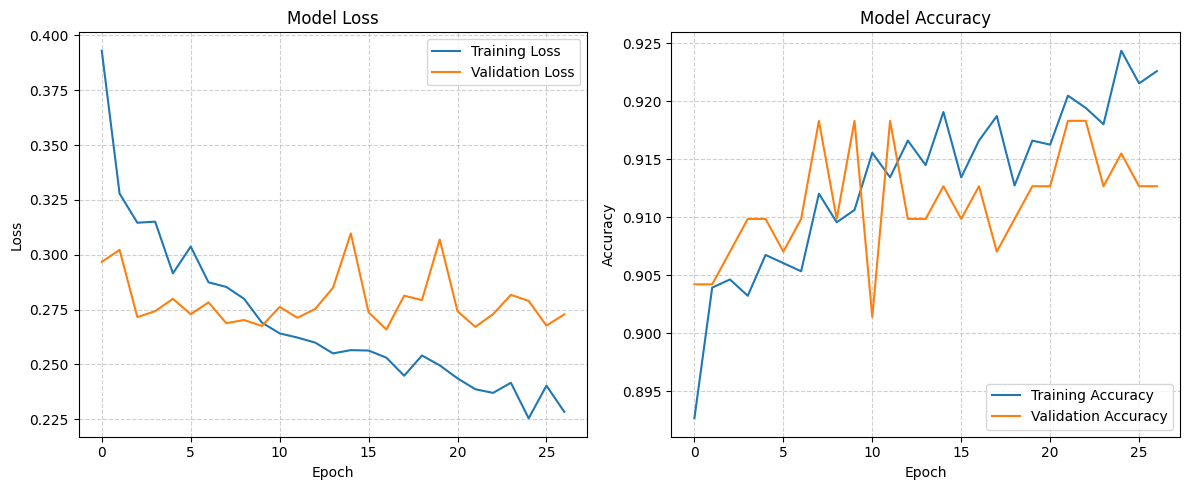

Model trained for 27 epochs
Best validation loss: 0.2659 (epoch 17)
Validation accuracy at best epoch: 0.9127


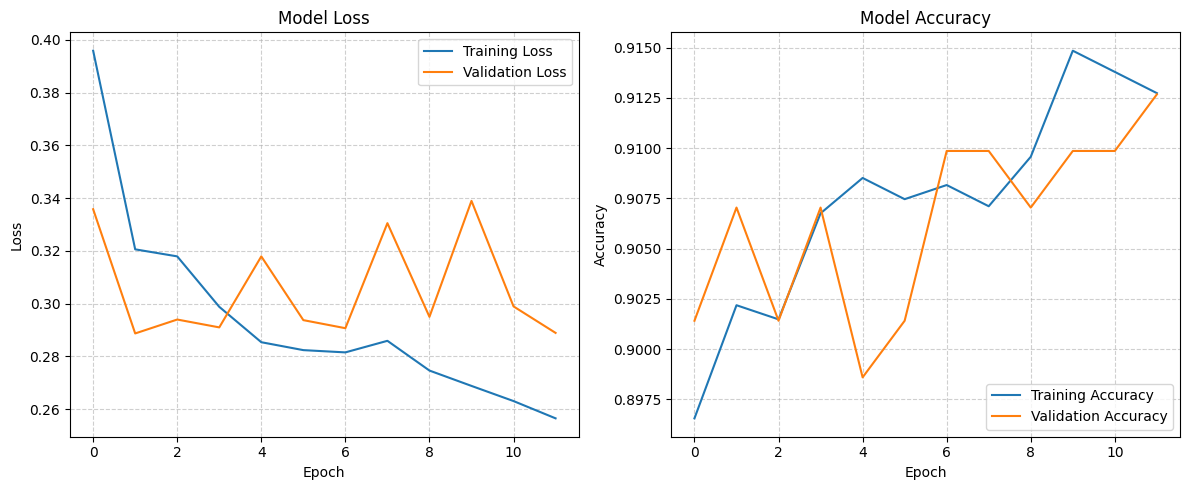

Model trained for 12 epochs
Best validation loss: 0.2887 (epoch 2)
Validation accuracy at best epoch: 0.9070


In [83]:
plot_training_history(hist_ft)
plot_training_history(hist_tfidf_ft)

In [97]:
import os
import pickle

# Create directory for saving models if it doesn't exist
os.makedirs('model/saved_models', exist_ok=True)

# Save XGBoost models
xgb_ft.save_model('model/saved_models/xgb_fasttext.json')
xgb_tfidf_ft.save_model('model/saved_models/xgb_tfidf_fasttext.json')

# Save Deep Learning models
dl_ft.save('model/saved_models/dl_fasttext.keras')
dl_tfidf_ft.save('model/saved_models/dl_tfidf_fasttext.keras')

# Save TF-IDF vectorizer
with open('model/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save label encoder
with open('model/saved_models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("All models saved successfully!")

All models saved successfully!


## Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results = {}

def evaluate_model(name, model, X_test, y_test, is_keras=False):
    if is_keras:
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred
    }

    print(f"\n----- {name} Evaluation -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

### XGBoost-Fasttext

/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 


----- XGBoost FastText Evaluation -----
Accuracy: 0.8989
Precision: 0.8493
Recall: 0.8989
F1 Score: 0.8561

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
     neutral       0.50      0.04      0.07        28
    positive       0.90      1.00      0.95       320

    accuracy                           0.90       356
   macro avg       0.47      0.34      0.34       356
weighted avg       0.85      0.90      0.86       356



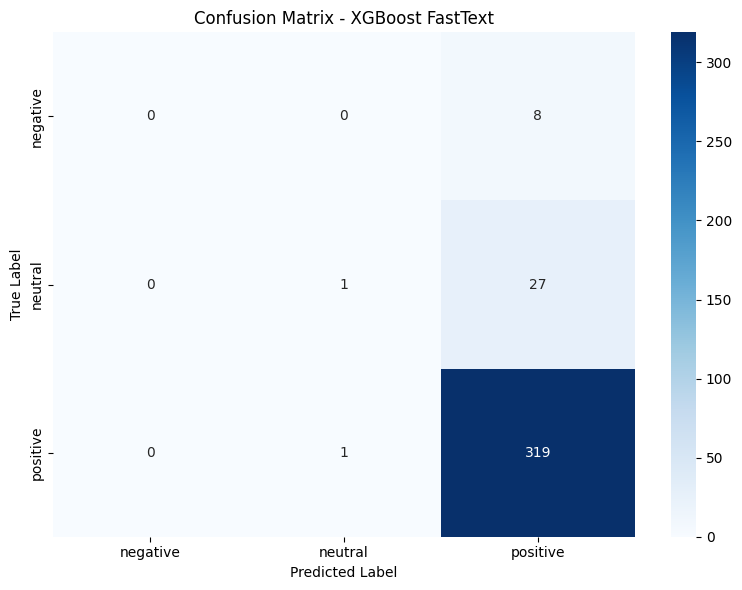

In [87]:
evaluate_model('XGBoost FastText', xgb_ft, X_test_ft, y_test)

### XGBoost-TFIDF-Fasttext


----- XGBoost TF-IDF FastText Evaluation -----
Accuracy: 0.8989
Precision: 0.8080
Recall: 0.8989
F1 Score: 0.8510

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
     neutral       0.00      0.00      0.00        28
    positive       0.90      1.00      0.95       320

    accuracy                           0.90       356
   macro avg       0.30      0.33      0.32       356
weighted avg       0.81      0.90      0.85       356



/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

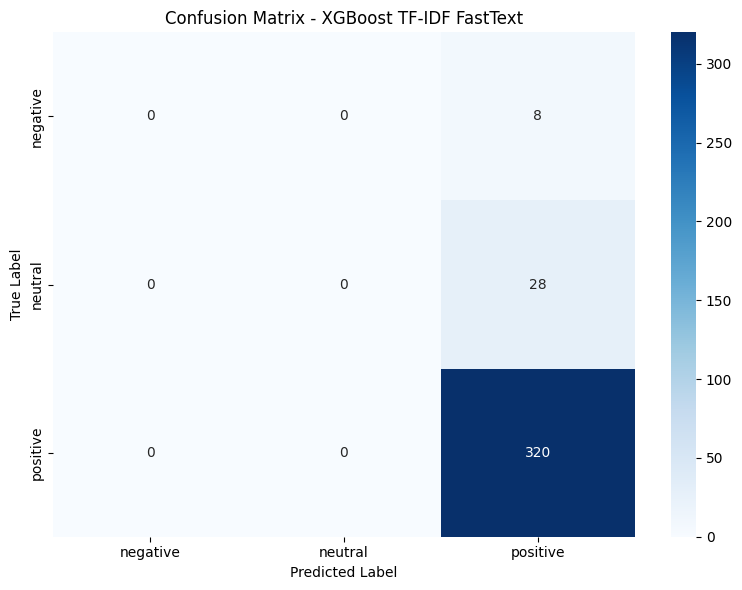

In [88]:
evaluate_model('XGBoost TF-IDF FastText', xgb_tfidf_ft, X_test_tfidf_ft, y_test)

### Deep Learning-Fasttext

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

----- Deep Learning FastText Evaluation -----
Accuracy: 0.8961
Precision: 0.8497
Recall: 0.8961
F1 Score: 0.8695

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
     neutral       0.31      0.14      0.20        28
    positive       0.92      0.98      0.95       320

    accuracy                           0.90       356
   macro avg       0.41      0.38      0.38       356
weighted avg       0.85      0.90      0.87       356



/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

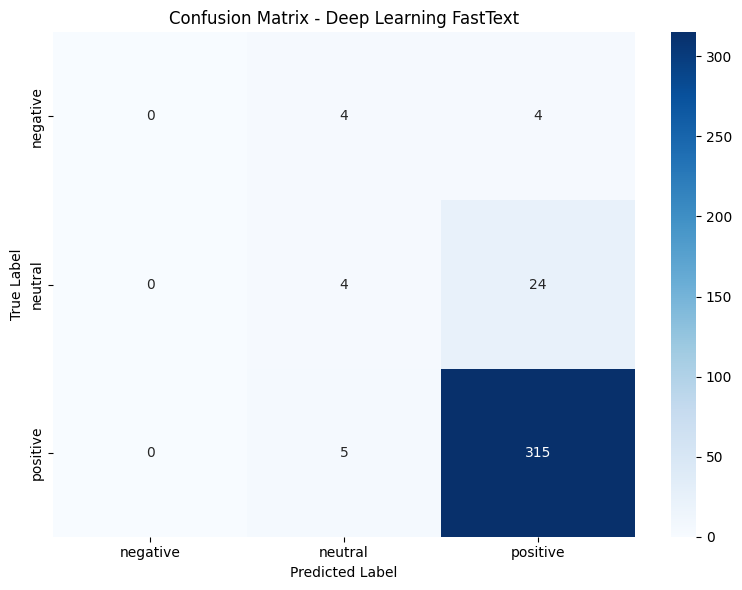

In [89]:
evaluate_model('Deep Learning FastText', dl_ft, X_test_ft, y_test, is_keras=True)

### Deep Learning-TFIDF-Fasttext

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

----- Deep Learning TF-IDF FastText Evaluation -----
Accuracy: 0.9073
Precision: 0.8667
Recall: 0.9073
F1 Score: 0.8716

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
     neutral       0.60      0.11      0.18        28
    positive       0.91      1.00      0.95       320

    accuracy                           0.91       356
   macro avg       0.50      0.37      0.38       356
weighted avg       0.87      0.91      0.87       356



/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

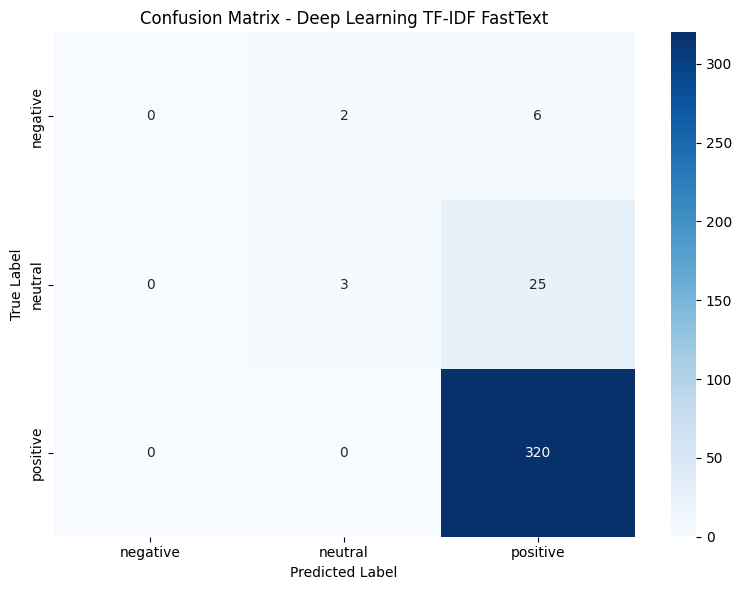

In [90]:
evaluate_model('Deep Learning TF-IDF FastText', dl_tfidf_ft, X_test_tfidf_ft, y_test, is_keras=True)

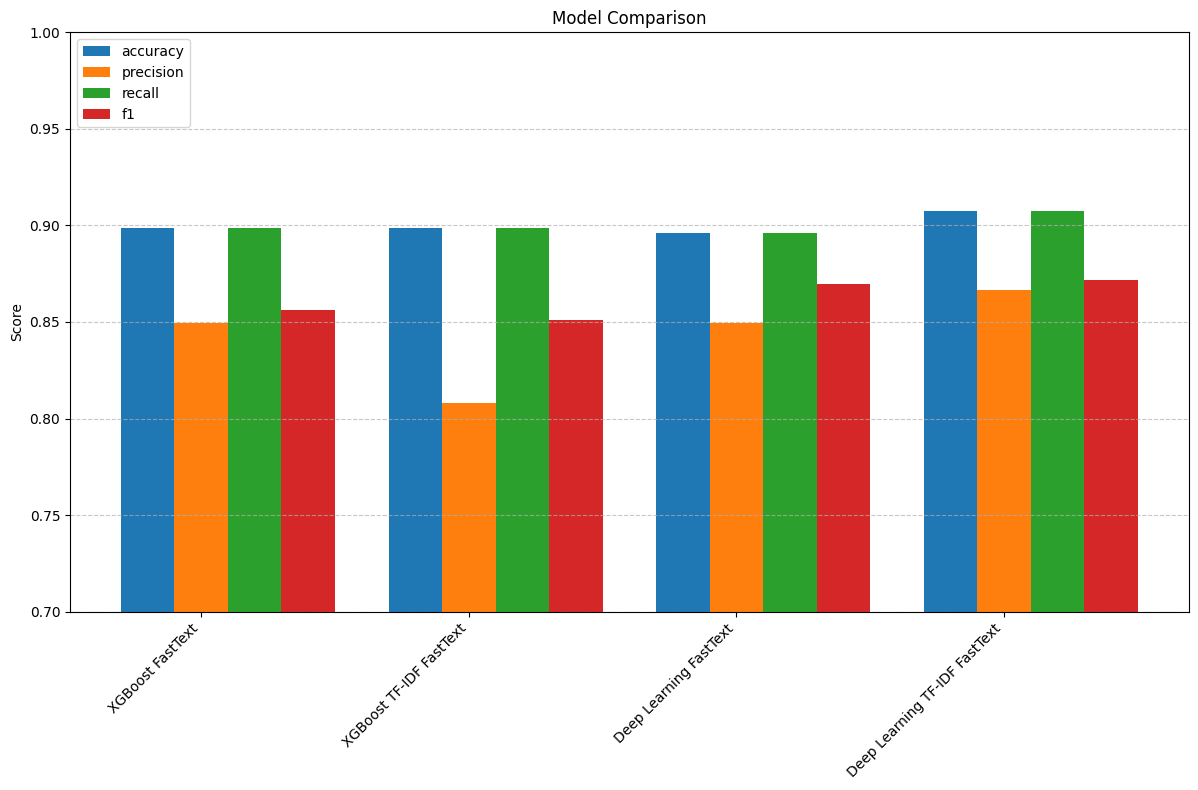

In [94]:
# Compare all models
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create comparison bar chart
plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    rects = plt.bar(x + offset, [results[model][metric] for model in model_names], width, label=metric)
    multiplier += 1

plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visibility
plt.show()

In [95]:
# Print summary table
print("\n----- Summary of Results -----")
for model in model_names:
    print(f"\n{model}:")
    for metric in metrics:
        print(f"  {metric.capitalize()}: {results[model][metric]:.4f}")


----- Summary of Results -----

XGBoost FastText:
  Accuracy: 0.8989
  Precision: 0.8493
  Recall: 0.8989
  F1: 0.8561

XGBoost TF-IDF FastText:
  Accuracy: 0.8989
  Precision: 0.8080
  Recall: 0.8989
  F1: 0.8510

Deep Learning FastText:
  Accuracy: 0.8961
  Precision: 0.8497
  Recall: 0.8961
  F1: 0.8695

Deep Learning TF-IDF FastText:
  Accuracy: 0.9073
  Precision: 0.8667
  Recall: 0.9073
  F1: 0.8716


## Inference Testing

The best-considered model is Deep Learning with TF-IDF+Fasttext. Therefore this inference is using that model. Below is the sample review.

![](sample_image.png)

In [101]:
review = "bahan nya bagus, tapi size tidak sesuai, cocok untuk BB 50 ke 55. Akhirnya saya kasih ke anak saya..."

review_vector = get_document_vector_tfidf(review)
review_vector = review_vector.reshape(1, -1)
predicted_class = dl_tfidf_ft.predict(review_vector)
predicted_class = np.argmax(predicted_class, axis=1)
predicted_label = le.inverse_transform(predicted_class)[0]
print(f"Predicted class for the review: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class for the review: positive
